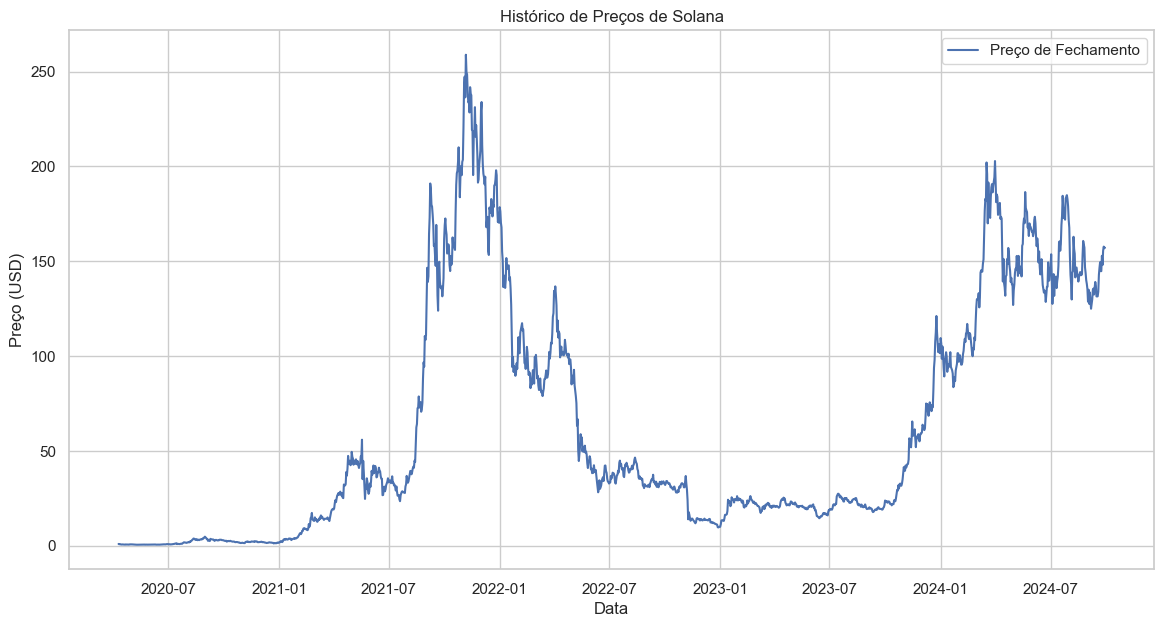

Acurácia: 0.48923076923076925
              precision    recall  f1-score   support

           0       0.48      0.52      0.50       158
           1       0.50      0.46      0.48       167

    accuracy                           0.49       325
   macro avg       0.49      0.49      0.49       325
weighted avg       0.49      0.49      0.49       325



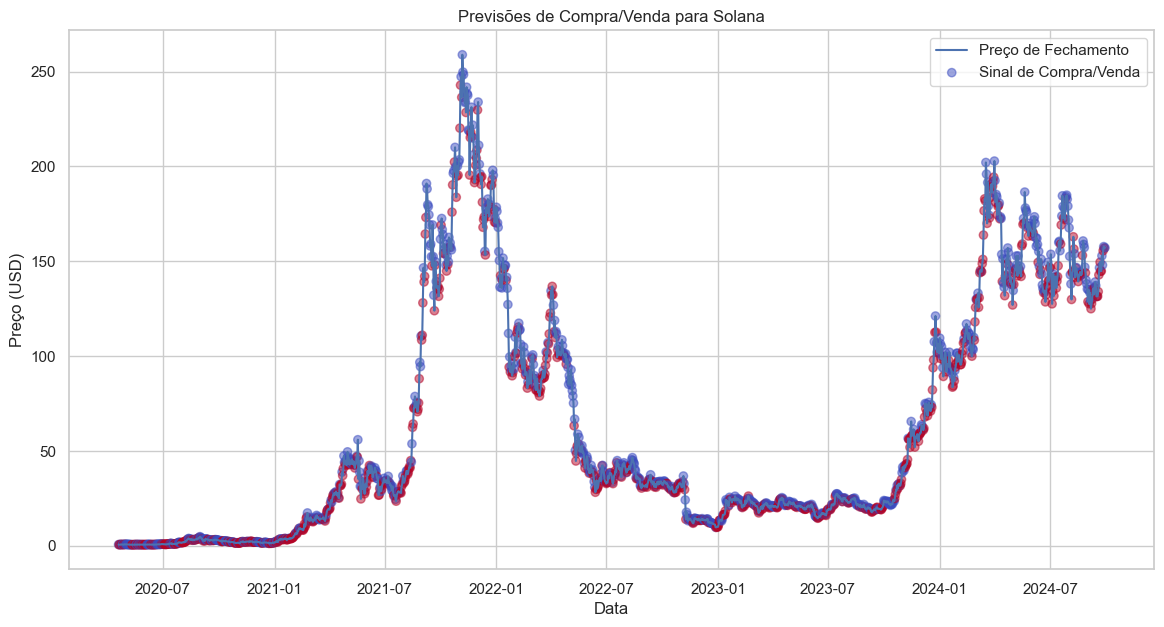

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Configurando estilos de gráficos
sns.set(style="whitegrid")

# 1. Obtenção dos Dados
sol = yf.Ticker("SOL-USD")
hist = sol.history(period="5y")
hist.reset_index(inplace=True)
hist = hist[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
hist.rename(columns={'Date': 'date', 'Open': 'open', 'High': 'high',
                    'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)

# 2. Análise Exploratória
plt.figure(figsize=(14,7))
plt.plot(hist['date'], hist['close'], label='Preço de Fechamento')
plt.title('Histórico de Preços de Solana')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

# 3. Engenharia de Features
hist['price_change'] = hist['close'].pct_change()
hist['moving_avg_5'] = hist['close'].rolling(window=5).mean()
hist['moving_avg_10'] = hist['close'].rolling(window=10).mean()
hist['volatility'] = hist['close'].rolling(window=10).std()
hist['target'] = np.where(hist['price_change'].shift(-1) > 0, 1, 0)  # 1: Comprar, 0: Vender
hist.dropna(inplace=True)

# 4. Preparação dos Dados para o Modelo
features = ['open', 'high', 'low', 'close', 'volume', 'moving_avg_5', 'moving_avg_10', 'volatility']
X = hist[features]
y = hist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Treinamento do Modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Avaliação do Modelo
y_pred = model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 7. Salvando o Modelo
joblib.dump(model, '../backend/models/solana_rf_model.joblib')

# 8. Visualização das Previsões
hist['prediction'] = model.predict(X)

plt.figure(figsize=(14,7))
plt.plot(hist['date'], hist['close'], label='Preço de Fechamento')
plt.scatter(hist['date'], hist['close'], c=hist['prediction'], cmap='coolwarm', label='Sinal de Compra/Venda', alpha=0.5)
plt.title('Previsões de Compra/Venda para Solana')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()
